## Main Question
Forecasting the number of daily female birth based on the path data!

### Data Understanding

We will use the **Daily Female Births in CA in 1959** dataset.  
The dataset describes the number of **daily** female births in California 1959.  

Provider: Time Series Data Library  
Provider source: Newton (1988)  
Source URL: http://datamarket.com/data/list/?q=provider:tsdl  
Units: Births  
Dataset metrics: 365 fact values in 1 timeseries.  
Time granularity: Date  
Time range: 1 Jan 1959 – 31 Dec 1959  

In [1]:
from pandas import read_csv
import pandas as pd

In [2]:
# Importing the dataset as a Series instead of a DataFrame

dataset = read_csv("Datasets/daily-total-female-births-CA.csv", header=0, index_col=0, parse_dates=True)

# header = 0 We must specify the header information at row 0.
# index_col = 0, We hint that the first column contains the index information for the time series.
# parse_dates = True, We give the function a hint that data in the first column contains dates that needs to be parsed.

In [3]:
dataset.head()

,births
date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 1959-01-01 to 1959-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   births  365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB


In [5]:
dataset.shape

(365, 1)

In [6]:
dataset.describe()

,births
count,365.000000
mean,41.980822
std,7.348257
min,23.000000
25%,37.000000
50%,42.000000
75%,46.000000
max,73.000000


In [7]:
dataset.isnull().sum()

births    0
dtype: int64

### Basic Feature Engineering  
Time series must be re-framed as a supervised learning dataset before we can start using ML algorithms. There is no concept of input and output features in time series.  
Instead, we must choose the variable to be predicted and use feature engineering to construct all of the inputs that will be used to make predictions for future time steps.

**From:**  
time 1,     value 1  
time 2,     value 2  

**To:**  
input 1,    output 1  
input 2,    output 2  

In time series there is no concept of input and output variables; we must **invent** these two and frame the supervised learning problem from **scratch**.  

The difficulty is that we don't know the underlying inherent functional relationship between inputs and outputs that we are trying to expose. The only feedback we have  
is the performance of the models developed on the supervised learning datasets or views of the problem we create.  

In [8]:
import matplotlib.pyplot as plt

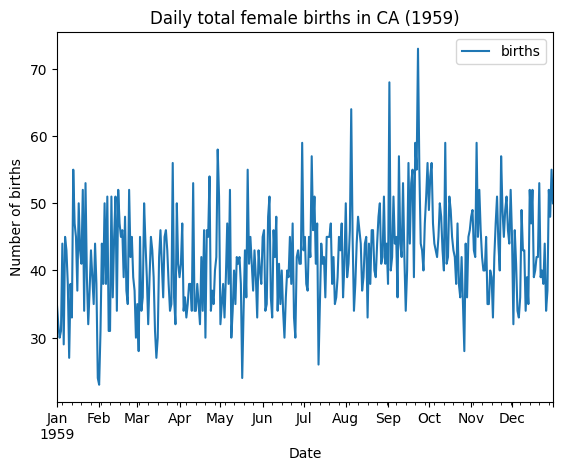

In [9]:
dataset.plot()
plt.title("Daily total female births in CA (1959)")
plt.xlabel('Date')
plt.ylabel('Number of births')
plt.show()

**Trend**: A trend refers to the long-term increase or decrease in the data over time. For example, if the number of births consistently increases or decreases throughout the year, that's a trend.  From the plot, it seems there might be an upward trend in August.

**Seasonality**: Seasonality refers to regular patterns that repeat at consistent intervals, such as monthly or yearly. If there are peaks and troughs that repeat every month or season, that's a sign of seasonality. There is a noticeable increase in August, which might suggest some seasonal effect.

**Cyclic Patterns**: Unlike seasonality, cyclic patterns occur at irregular intervals. These are typically influenced by broader economic or environmental factors.

**Noise**: Noise is the random variation that is not part of the trend or seasonality. It's the “ups and downs” you see in the plot.

**To further analyze** these components, we can decompose the time series into trend, seasonal, and residual (noise) components using libraries like statsmodels.  

Decomposing a time series is the process of breaking down the data into its fundamental components:  
trend, seasonality, and residual (or noise). Each of these components helps us understand different aspects of the data, making it easier to analyze and forecast.  

**Why Decomposition is Needed:**  

1. **Simplification**: Breaking down a complex time series into simpler components makes it easier to understand and interpret.

2. **Enhanced Forecasting**: By understanding the underlying components, we can create more accurate forecasting models. For example, if we know the seasonal pattern, we can adjust our forecasts accordingly.

3. **Anomaly Detection**: Identifying the residual component helps in detecting outliers or anomalies that do not fit the regular pattern of the data.

4. **Insight Extraction**: Decomposition provides insights into the underlying structure of the data, helping in decision-making and strategic planning.

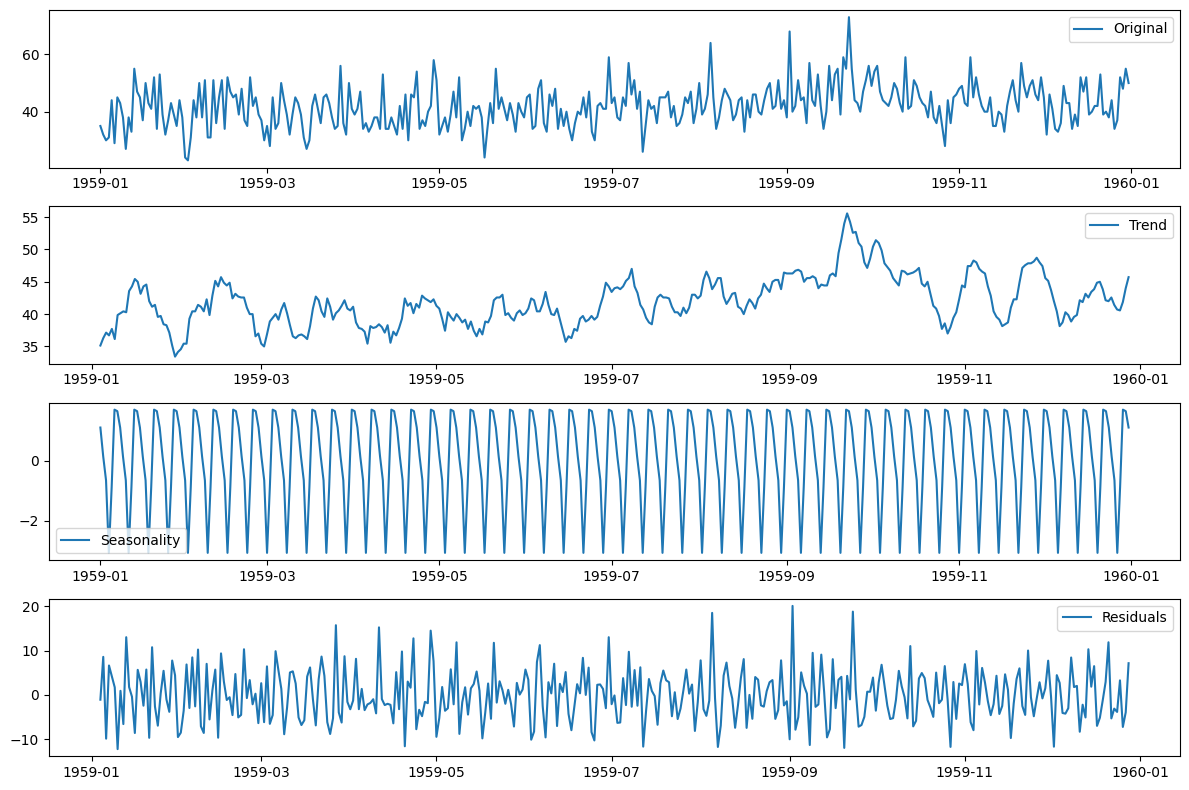

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(dataset, model='additive')

# Extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(dataset, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Model Building  

1. Define the size of the training set: Typically, in time series analysis, the training set is larger than the testing set.  
A common practice is to use 70-80% of the data for training and the remaining 20-30% for testing.

2. Split the dataset: You can use the indexing method to split the data. Here's an example using an 80-20 split:

In [11]:
# Define the split point
split_point = int(len(dataset) * 0.8)

# Split the data
train = dataset[:split_point]
test = dataset[split_point:]

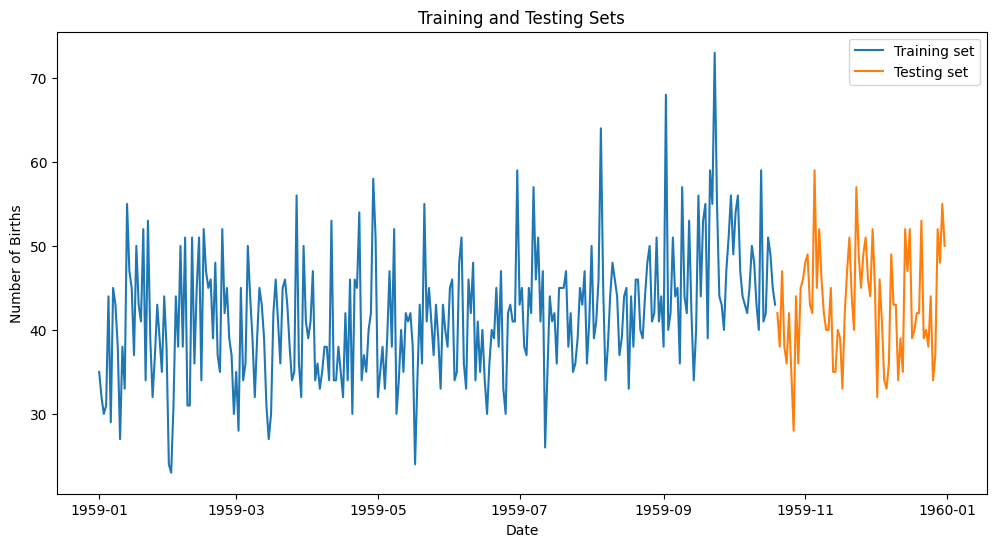

In [12]:
# Plot the training and testing sets: This helps visualize the split and ensures that it was done correctly.
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training set')
plt.plot(test, label='Testing set')
plt.title('Training and Testing Sets')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.show()

### Training the ARIMA model
1. **p** (autoregressive part): This is the number of lag observations included in the model. It can be determined by examining the Partial Autocorrelation Function (PACF) plot.

2. **d** (differencing): This is the number of times the data needs to be differenced to become stationary. You can use the Augmented Dickey-Fuller test to check for stationarity.

3. **q** (moving average part): This is the size of the moving average window. It can be determined by examining the Autocorrelation Function (ACF) plot.

**Augmented Dickey-Fuller (ADF) Test**  

The ADF test is used to check for stationarity. It tests the null hypothesis that a unit root is present in the time series, which would indicate non-stationarity. Here are the key components:

1. **ADF Statistic**: A negative number where more negative values indicate stronger evidence against the null hypothesis (suggesting the data is stationary).

2. **p-value**: The probability that the observed data would occur if the null hypothesis were true. A lower p-value means we can reject the null hypothesis with higher confidence.

In [13]:
from statsmodels.tsa.stattools import adfuller

# Plot the time series and use the Augmented Dickey-Fuller (ADF) test to see if the data is stationary.
result = adfuller(train)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -3.413773395518571
p-value: 0.010498203476885756


A time series is said to be stationary if its statistical properties, such as mean, variance, and autocorrelation, are constant over time.  
**Stationarity** is crucial in time series forecasting because many models (like ARIMA) assume that the data is stationary.  

**ADF Statistic**: -3.41

**p-value**: 0.010

Threshold for p-value:  
Typically, a p-value less than 0.05 is considered statistically significant.

Given your p-value is 0.010 (which is less than 0.05), you can reject the null hypothesis. This means your data does not have a unit root and is therefore **stationary**.  

**Why is Stationarity Important?**  
1. **Model Assumptions**: Many forecasting models assume stationarity to provide accurate and reliable predictions.

2. **Simplifies Analysis**: Stationary series are easier to predict and analyze since their properties do not change over time.

**Plotting ACF and PACF**  
From the ACF plot, identify where the lag value crosses the significance line for the first time to determine q.  

From the PACF plot, identify where the lag value crosses the significance line for the first time to determine p.

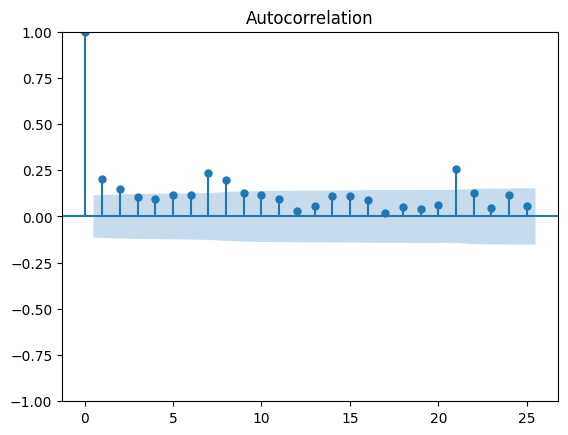

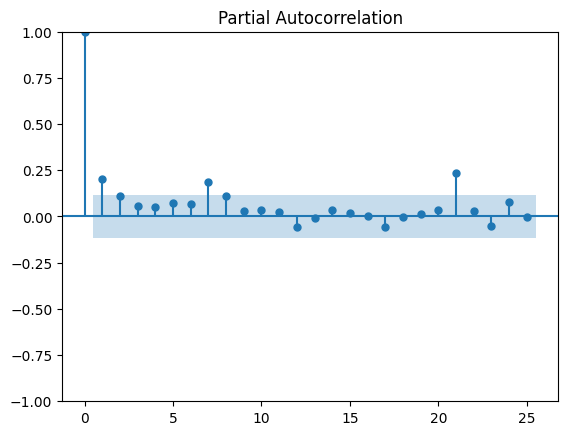

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train)
plot_pacf(train)
plt.show()

**Y-Axis at 1**: The first lag on the ACF plot is always 1 because any series is perfectly correlated with itself at lag 0.

**Autocorrelation Drops**: Subsequent points indicate the autocorrelation at different lags. In your plot, autocorrelation quickly drops to values around 0 - 0.25, suggesting that the autocorrelations diminish rapidly.

**Significant Lags**: Look for points where the autocorrelation exceeds the significance bounds (typically shown as dashed lines). If the autocorrelation is significant at lag k, it suggests the presence of a Moving Average (MA) component.

Let's assume the value of 1, 1, 1 for 'p', 'd' and 'q'.

In [ ]:
# Import the ARIMA class from statsmodels
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
model = ARIMA(train, order=(1, 1, 1))

In [16]:
model_fit = model.fit()

# Print a summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 births   No. Observations:                  292
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -985.074
Date:                Fri, 01 Nov 2024   AIC                           1976.149
Time:                        19:57:16   BIC                           1987.169
Sample:                    01-01-1959   HQIC                          1980.563
                         - 10-19-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0734      0.066      1.116      0.264      -0.056       0.202
ma.L1         -0.9563      0.021    -45.604      0.000      -0.997      -0.915
sigma2        50.6241      3.667     13.804      0.0

**Model Diagnostics**  
After fitting the model, it's important to check the residuals (errors) to ensure they look like white noise. This means the model has captured all the information in the data and the residuals are random.

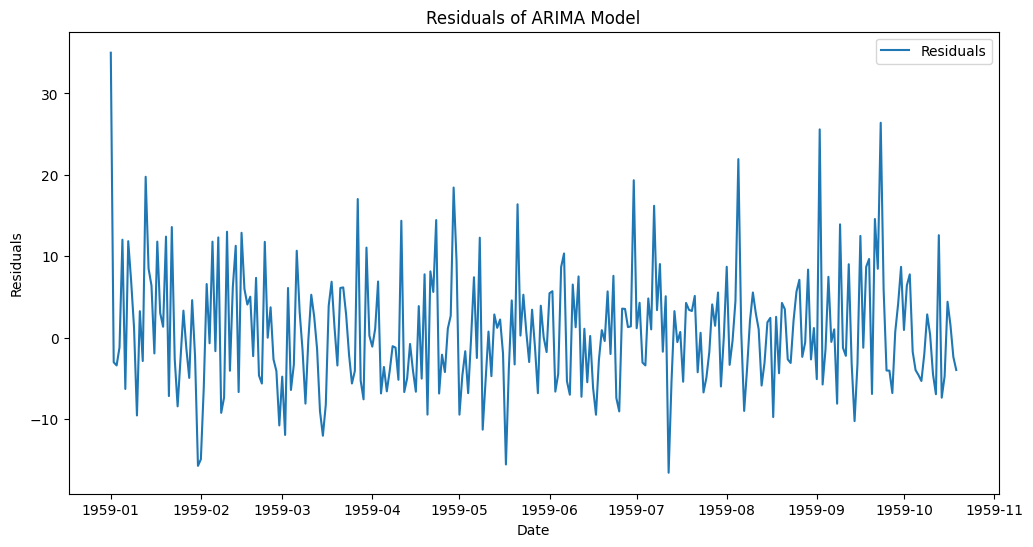

In [17]:
# Plot residual errors
residuals = model_fit.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals')
plt.title('Residuals of ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

**Making Predictions**  

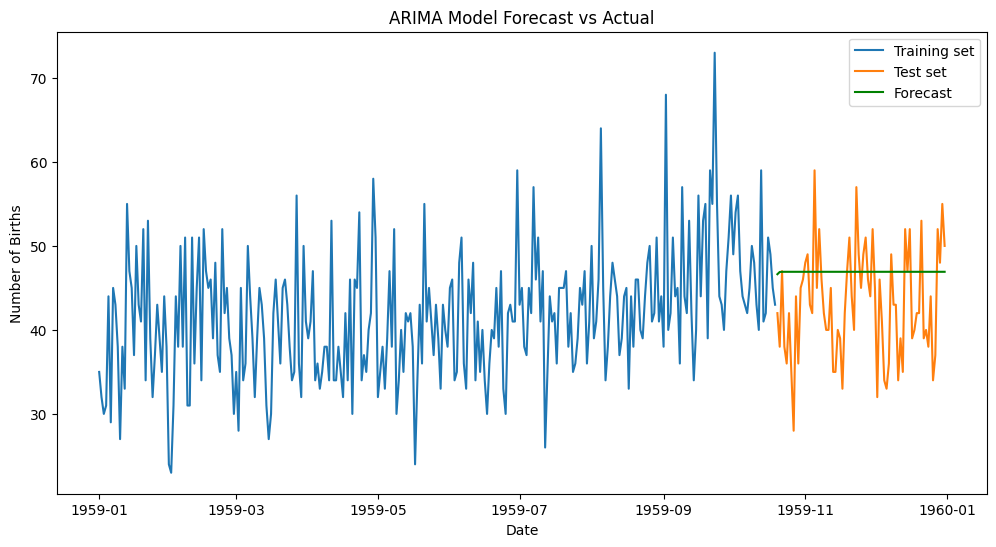

In [22]:
# Forecast
forecast = model_fit.forecast(steps=len(test))

# Plot the forecast along with the actual data
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training set')
plt.plot(test, label='Test set')
plt.plot(test.index, forecast, label='Forecast', color='green')
plt.title('ARIMA Model Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.show()


A horizontal line in the forecast suggests that the model is predicting a constant value over the test period. This often happens when the model isn't able to capture the patterns in the data effectively.  
We need to Fine-Tune the ARIMA Parameters.